In [2]:
from numpy.random import seed
seed(42)
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

2023-12-02 06:54:04.155547: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 06:54:04.177159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 06:54:04.177188: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 06:54:04.177203: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 06:54:04.181596: I tensorflow/core/platform/cpu_feature_g

In [3]:
from utils import load_data, vis_data, general_preprocessing, get_dataset, draw_saliency, draw_CAM, get_results

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import os
import json

In [4]:
#Se crea una lista para cada clase de imágenes y se guardan en cada una los paths correspondientes
lung_aca, lung_n, lung_scc = load_data()

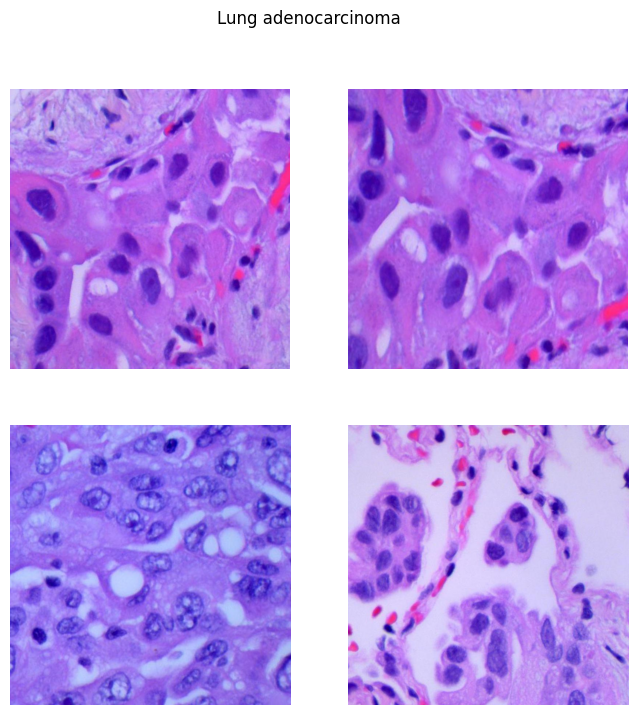

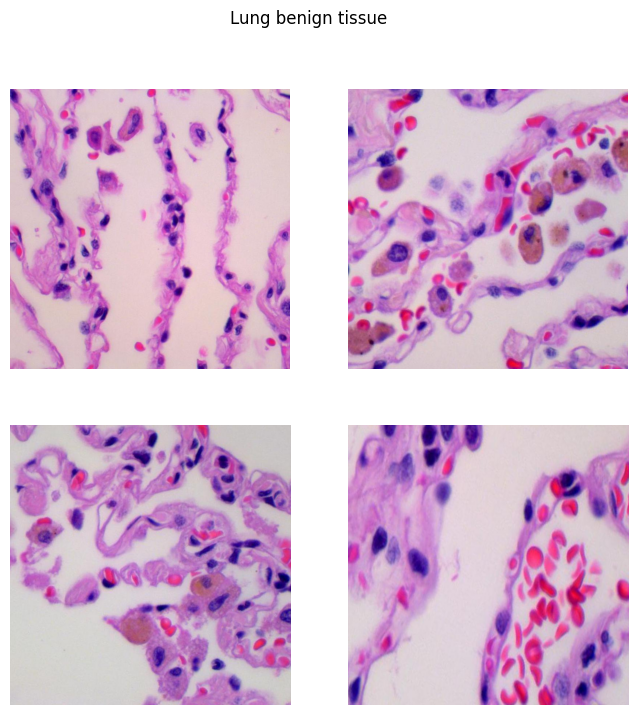

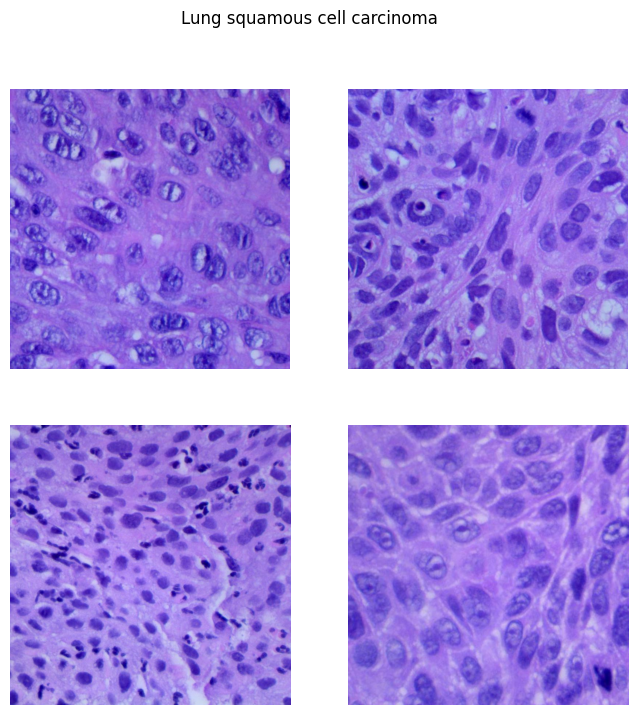

In [5]:
#Se previsualizan las imágenes.
vis_data(lung_aca, lung_n, lung_scc)

In [6]:
# Se crean las variables necesarias para la normalización de las imágenes:

alfa = 1 #alfa defines the width of the input intensity range
beta = 0 #beta defines the intensity around which the range is centered
# Información sobre parámetros alfa y beta en: https://itk.org/ItkSoftwareGuide.pdf

def preprocessing_efficient(image_path, label): #Inicialmente usaremos el mismo preprocesado que en la SimpleConv!

    image, label = general_preprocessing(image_path, label)
    
    hsv_image = tf.image.rgb_to_hsv(image)
    n_image = (255-0)*(1/(1+tf.math.exp((-1)*((hsv_image[:,:,2]- beta)/ alfa))))
    #La linea superior es una normalización NO lineal    
    
    norm_image = tf.stack([hsv_image[:,:,0], hsv_image[:,:,1], n_image], axis = -1)
    norm_image = tf.image.hsv_to_rgb(norm_image)
     
    norm_image = tf.cast(norm_image, tf.float32) / 255.0  
    
    return norm_image, label

In [7]:
#Se dividen los datos en los conjuntos de training, validation y testing.
train_dataset, val_dataset, test_dataset = get_dataset(preprocessing_efficient, lung_aca, lung_n, lung_scc)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2023-12-02 06:54:06.868173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 06:54:06.880405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-02 06:54:06.880520: I tensorflow/compiler/

In [8]:
##En la Efficient, se usan Separable DepthWise Convolutions, que se aplican por separado a cada canal del input!

In [9]:
#Se crea el modelo.

Efficient = tf.keras.models.Sequential([

  tf.keras.layers.InputLayer(input_shape = (350, 350, 3)),

  tf.keras.layers.SeparableConv2D(filters = 32, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.GaussianNoise(0.01),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.SeparableConv2D(filters = 64, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.GaussianNoise(0.01),
  tf.keras.layers.Dropout(0.2),


  tf.keras.layers.SeparableConv2D(filters = 128, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.SeparableConv2D(filters = 256, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.SeparableConv2D(filters = 512, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.SeparableConv2D(filters = 512, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.SeparableConv2D(filters = 512, kernel_size = (5, 5), padding = 'SAME'), #Kernel size más grande para tener menos parámetros
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(), #La capa Flatten es para tener los datos en una sola dimensión, las capas siguientes ya serán fully-connected.
  tf.keras.layers.Dense(2048),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2), #Augmenta la generalització perquè fa que un % de les neurones siguin 0 cada vegada, de manera que les altres han de 'fxar-se més' en els canvis.
  tf.keras.layers.Dense(1024),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(8),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Softmax()

])
#Las capas Dropout aumentan la generalitzación porque se asegura de que un % de las neuronas tengan un weigth de 0 cada vez,
#de manera que las otras tienen que 'fijarse' más en los datos.

In [13]:
Efficient.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separabl  (None, 350, 350, 32)      155       
 eConv2D)                                                        
                                                                 
 max_pooling2d (MaxPooling2  (None, 175, 175, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 175, 175, 32)      128       
 Normalization)                                                  
                                                                 
 gaussian_noise (GaussianNo  (None, 175, 175, 32)      0         
 ise)                                                            
                                                                 
 dropout (Dropout)           (None, 175, 175, 32)      0

In [3]:
#En las siguientes celdas se definen los callbacks a usar

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [11]:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [10]:
checkpoint_filepath = '../ModelCheckpoints/Efficient_alfa1.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    start_from_epoch=0
)

In [14]:
Efficient.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])

In [15]:
history1 = Efficient.fit(
    train_dataset,
    epochs=100,
    batch_size=32,
    validation_data = val_dataset,
    callbacks = [learning_rate_scheduler, model_checkpoint_callback, early_stop])

Epoch 1/100


2023-11-14 12:06:50.697410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-14 12:06:51.139722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-14 12:06:51.256882: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 12:06:51.628037: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f060c0496c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 12:06:51.628055: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-11-14 12:06:51.631359: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer,

375/375 [==============================] - 81s 203ms/step - loss: 0.4740 - accuracy: 0.7814 - val_loss: 1.5397 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/100
375/375 [==============================] - 74s 196ms/step - loss: 0.2894 - accuracy: 0.8876 - val_loss: 0.4265 - val_accuracy: 0.8420 - lr: 1.0000e-04
Epoch 3/100
375/375 [==============================] - 74s 196ms/step - loss: 0.2217 - accuracy: 0.9163 - val_loss: 0.2606 - val_accuracy: 0.8847 - lr: 1.0000e-04
Epoch 4/100
375/375 [==============================] - 73s 196ms/step - loss: 0.1881 - accuracy: 0.9266 - val_loss: 0.2833 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 5/100
375/375 [==============================] - 73s 196ms/step - loss: 0.1673 - accuracy: 0.9346 - val_loss: 0.4431 - val_accuracy: 0.8227 - lr: 1.0000e-04
Epoch 6/100
375/375 [==============================] - 73s 194ms/step - loss: 0.1520 - accuracy: 0.9388 - val_loss: 0.3970 - val_accuracy: 0.8627 - lr: 1.0000e-04
Epoch 7/100
375/375 [=============

In [11]:
Efficient.load_weights("../ModelCheckpoints/Efficient_alfa1.h5")

In [13]:
y_pred_Efficient = Efficient.predict(test_dataset)

47/47 [==============================] - 2s 47ms/step


In [20]:
#Se guardan las predicciones en un fichero json, por si se quisieran acceder sin cargar el modelo.
with open('predEfficient_alfa1', 'w') as file:
    json.dump(y_pred_Efficient.tolist(), file)

In [21]:
results_Efficient = get_results(test_dataset, y_pred_Efficient)
print(results_Efficient)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       500
           1       0.98      1.00      0.99       500
           2       0.96      0.92      0.94       500

   micro avg       0.95      0.95      0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500
 samples avg       0.95      0.95      0.95      1500



In [22]:
#Visualicación para evaluar la explicabilidad del modelo:

In [23]:
#Se generantres números aleatorios para decidir qué imagenes usar para crear los Saliency Maps y Class Activation Maps.
#Al generarse los números aleatorios a partir de la misma semilla, serán los mismos en todas las notebooks.

aca_random = random.randint(1, 5000)
n_random = random.randint(1, 5000)
scc_random = random.randint(1, 5000)

In [6]:
aca_random, n_random, scc_random

(913, 205, 2254)

In [7]:
#Se generan los paths correspondientes a las imágenes seleccionadas aleatoriamente.

aca_path = '../lung_image_sets/lung_aca/lungaca' + str(aca_random) +'.jpeg'
n_path = '../lung_image_sets/lung_n/lungn' + str(n_random) +'.jpeg'
scc_path = '../lung_image_sets/lung_scc/lungscc' + str(scc_random) +'.jpeg'

In [8]:
#Se crea una lista con los paths en cuestión

selected_images = [aca_path, n_path, scc_path]

#### Saliency Map

In [9]:
# Se crea una lista con los paths en los que guardar los Saliency Maps de esta red neuronal para cada una de las imágenes seleccionadas.
saliency_paths = ['./SalMaps/aca_Efficient.jpg', './SalMaps/n_Efficient.jpg', './SalMaps/scc_Efficient.jpg']

2023-11-19 07:47:03.335384: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-19 07:47:03.409273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905


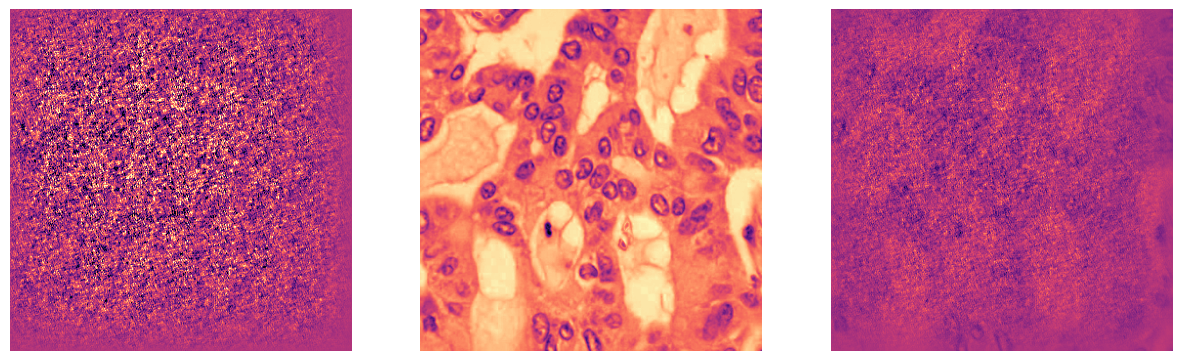

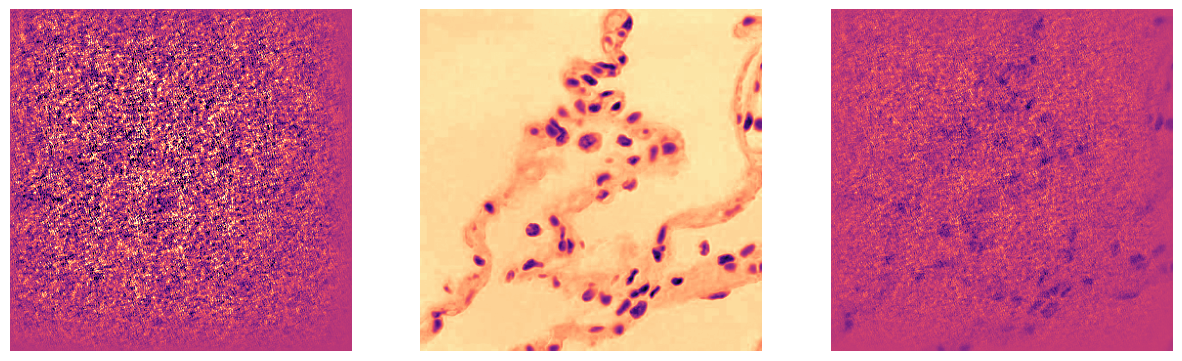

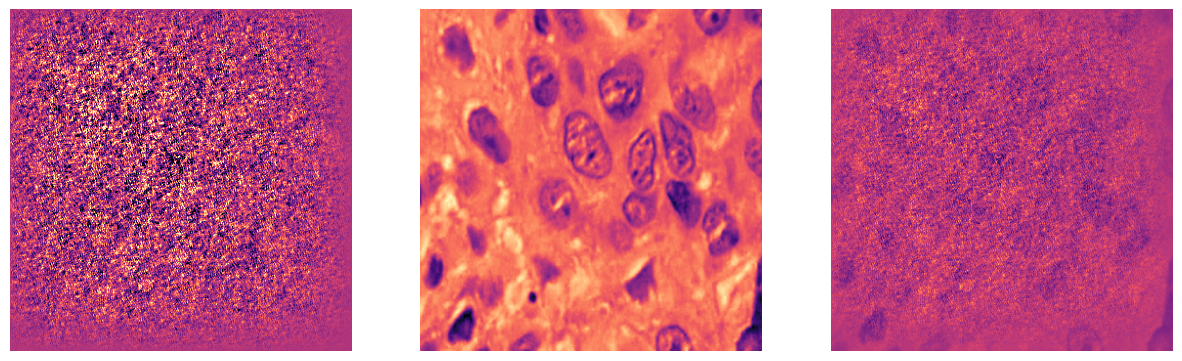

In [10]:
# Se generan los Saliency Maps, se muestran por pantalla y se guardan en los paths correspondientes.
for i in range(len(selected_images)):
    draw_saliency(selected_images[i], Efficient, preprocessing_efficient, saliency_paths[i])

#### Class Activation Map

In [11]:
#Se declaran variables necesarias para draw_CAM
img_size = (350, 350)
alpha = 1

In [13]:
# Se crea una lista con los paths en los que guardar los Class Activation Maps de esta red neuronal para cada una de las imágenes seleccionadas.
cam_paths = ['./CamMaps/aca_Efficient.jpg', './CamMaps/n_Efficient.jpg', './CamMaps/scc_Efficient.jpg']

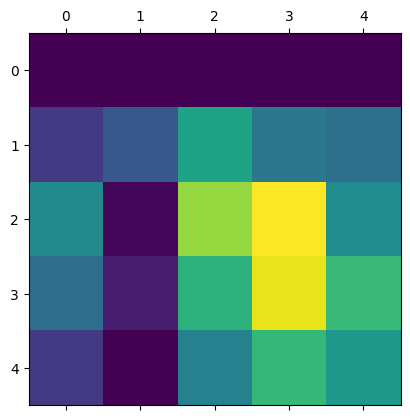

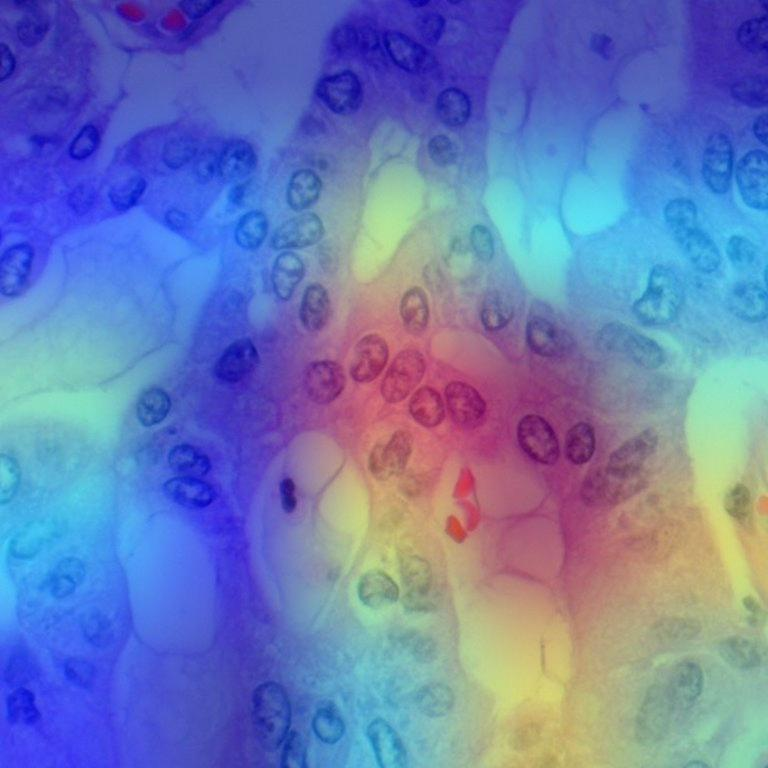

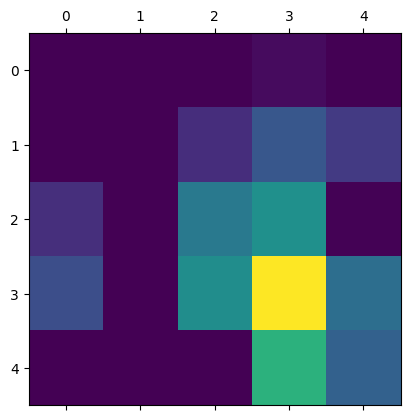

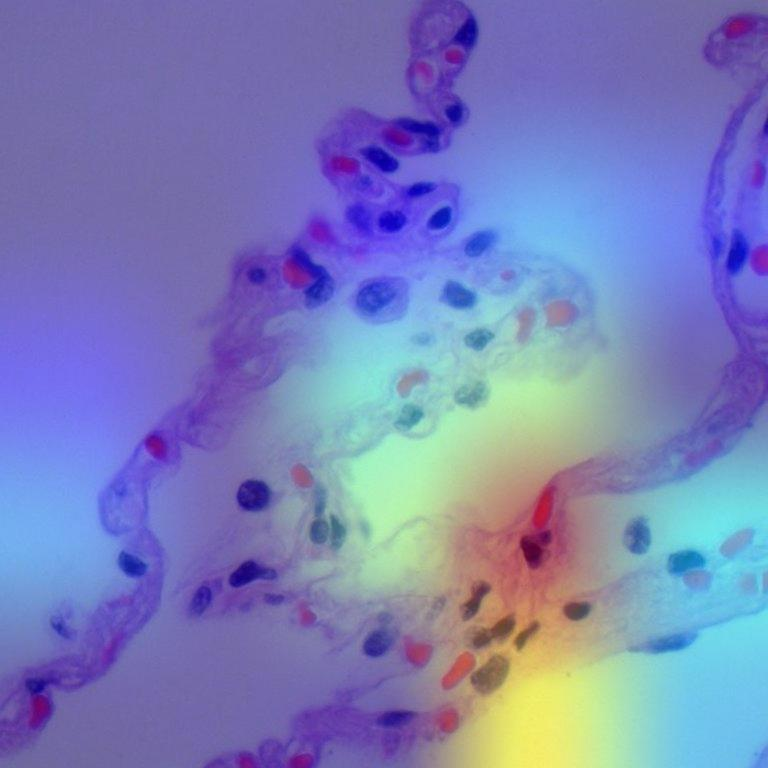

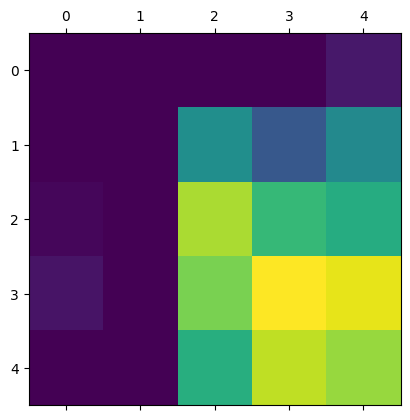

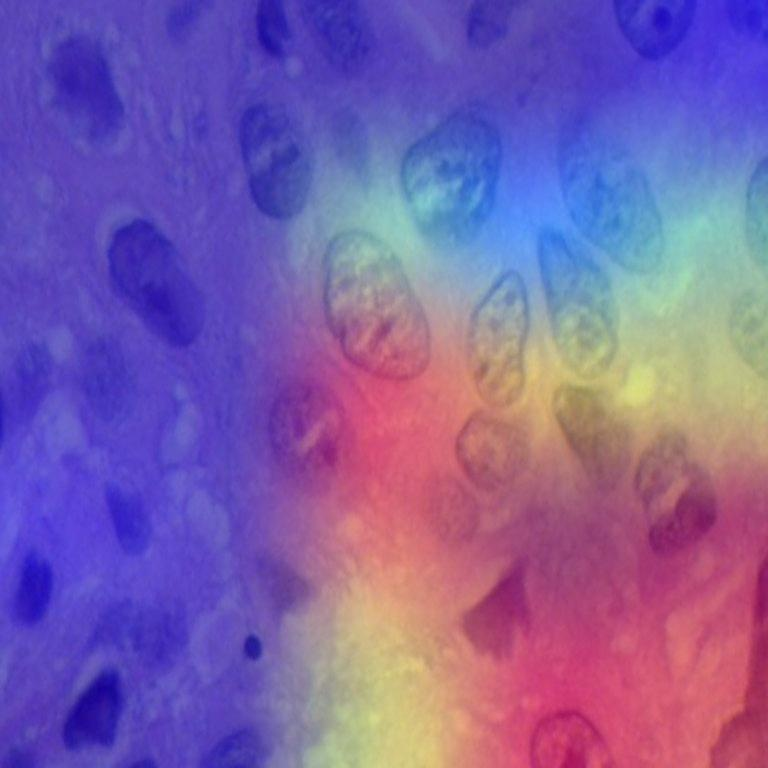

In [14]:
# Se generan los Class Activation Maps, se muestran por pantalla y se guardan en los paths correspondientes.
for i in range(len(selected_images)):
    draw_CAM(selected_images[i], img_size, Efficient, 'efficient', cam_paths[i], alpha, preprocessing_efficient, pred_index = None)